<a href="https://colab.research.google.com/github/lupa123/Stock-Prediction-with-Scikit-Learn/blob/master/Predicting_Stocks_Price_with_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [17]:
# extract Apple Stocks Price
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 9, 4)
df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-28,205.720001,203.320007,204.100006,205.529999,15938800.0,205.529999
2019-08-29,209.320007,206.660004,208.500000,209.009995,20990500.0,209.009995
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005
2019-09-03,206.979996,204.220001,206.429993,205.699997,20023000.0,205.699997
2019-09-04,209.470200,207.320007,208.389999,209.055099,13261223.0,209.055099


In [0]:
# Feature Engineering
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [0]:
# Pre-processing & Cross Validation

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_forecast = X[-forecast_out:] 
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [0]:
# Split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 0)

In [0]:
 #Train the algorithm
  
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(x_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(x_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(x_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(x_train, y_train)

# Ridge Regression with built-in cross-validation of the alpha parameter
ridgeCV = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
ridgeCV.fit(x_train, y_train)

# Lasso
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(x_train, y_train)

# lasso model implemented using the LARS algorithm
lassoLars = linear_model.LassoLars(alpha=.1)
lassoLars.fit(x_train, y_train)

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)

In [0]:
 #Evaluation
  
confidencereg = clfreg.score(x_test, y_test)
confidencepoly2 = clfpoly2.score(x_test,y_test)
confidencepoly3 = clfpoly3.score(x_test,y_test)
confidenceknn = clfknn.score(x_test, y_test)
confidenceRidgeCV = ridgeCV.score(x_test, y_test)
confidenceLasso = lasso.score(x_test, y_test)
confidenceLassoLars = lassoLars.score(x_test, y_test)
print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)
print('The Ridge Regression confidence is ', confidenceRidgeCV)
print('The Lasso confidence is ', confidenceLasso)
print('The LassoLars confidence is ', confidenceLassoLars)

The linear regression confidence is  0.9627384062967468
The quadratic regression 2 confidence is  0.9653656605554309
The quadratic regression 3 confidence is  0.9663035094805398
The knn regression confidence is  0.9445368629480068
The Ridge Regression confidence is  0.962741011614956
The Lasso confidence is  0.9628027741517736
The LassoLars confidence is  0.9562733342819544


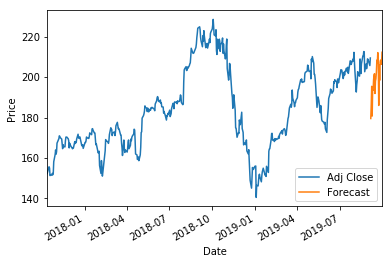

In [0]:
 #Plotting the Prediction
forecast_set = clfpoly3.predict(X_forecast)
dfreg['Forecast'] = np.nan
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
    
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()